# Features importances sur 4 classes du modèle CatBoost

### Imports

In [1]:
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.set_option('display.max_columns', None)
## Import des scripts python
import sys
import os
sys.path.append(os.path.abspath('../../python_scripts/'))

#import load_datas
import train_model as train
import save_model as saveModel
#import pickle_model

# Rechargement en cas de modification
import importlib
#importlib.reload(train)
#importlib.reload(saveModel)
#importlib.reload(pickle_model)

### Chargement des shap values de la classe 3 (Tué)

/Users/thierno/Documents/DataScientest/Final_Project/MAR24_CDS_Accidents/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


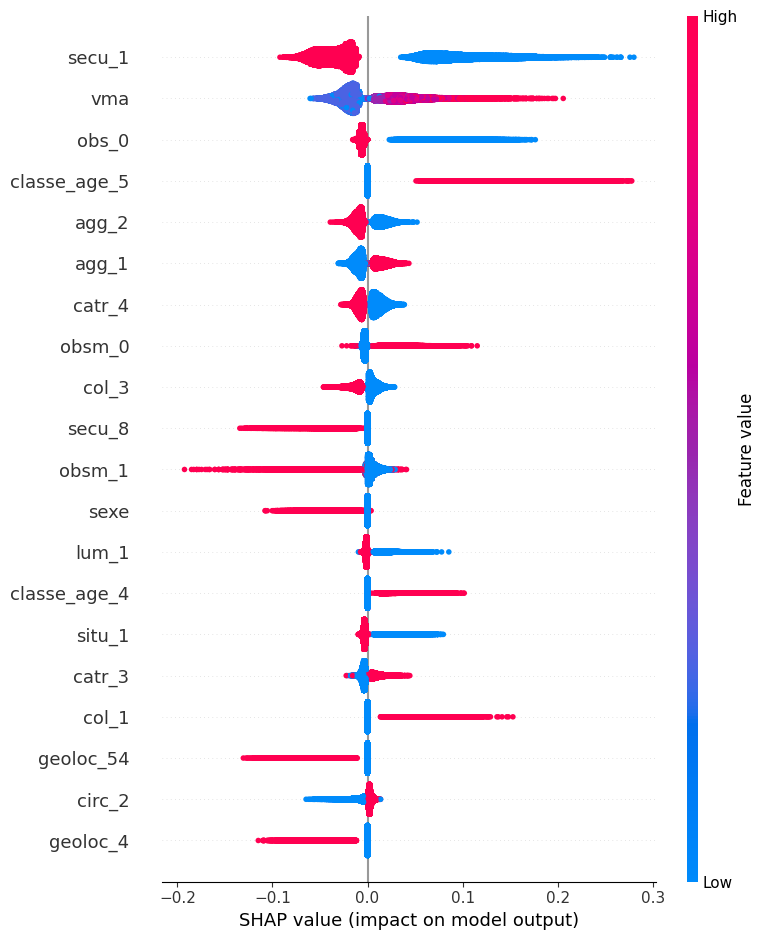

In [2]:
import shap

shap_df= pd.read_csv("shape_value_files/1_final_catboost_values_data_classe_3_geo.zip", \
                      compression=dict(method='zip', archive_name='1_final_catboost_values_data_classe_3_geo.csv'))

X_test = pd.read_csv("../../../../Data/X_test.zip", compression=dict(method='zip', archive_name='X_test.csv'))

shap_df= shap_df.drop(columns=['x_test_instance','base_values'])

shap_values_csv = shap_df.values

feature_names = shap_df.columns

shap_exp = shap.Explanation(values=shap_values_csv, data=X_test, feature_names=feature_names)

shap.summary_plot(shap_exp)


### Groupement des variables catégorielles

In [3]:
# Creer un dataframe avec les valeurs absolue des shap values
df_shap=pd.DataFrame(np.abs(shap_values_csv), columns=X_test.columns)

column_groups = {}

# Regroupement des colonnes
for col in X_test.columns:
    prefix = col.split('_')[0]  
    if prefix not in column_groups:
        column_groups[prefix] = []
    column_groups[prefix].append(col)

df_avg = pd.DataFrame()

# Calculer les moyennes pour chaque groupe de variable
for prefix, columns in column_groups.items():
    df_avg[f'{prefix}'] = df_shap[columns].mean(axis=1) 

# Afficher le DataFrame des moyennes des observations
display(df_avg.head(3))


,mois,lum,agg,int,atm,col,catr,circ,vosp,prof,plan,surf,infra,situ,catv,obs,obsm,choc,manv,motor,place,catu,trajet,hh,classe,geoloc,nbv,vma,sexe,secu,weekend
0,0.000340,0.000449,0.015797,0.001994,0.0,0.002103,0.002124,0.007174,0.001545,0.000000,0.000212,0.0,0.0,0.000708,0.001128,0.000470,0.001318,0.001492,0.000504,0.002947,0.000112,0.000636,0.001763,0.000263,0.005492,0.000299,0.012748,0.016546,0.0,0.010384,0.0
1,0.001219,0.000174,0.028822,0.001501,0.0,0.013344,0.005817,0.002335,0.000000,0.005552,0.001893,0.0,0.0,0.000898,0.000181,0.000399,0.003347,0.001374,0.005280,0.000000,0.000400,0.000570,0.002248,0.000000,0.001969,0.000013,0.001357,0.079668,0.0,0.006960,0.0
2,0.000978,0.008795,0.010356,0.000753,0.0,0.002753,0.002159,0.000698,0.000260,0.000000,0.000197,0.0,0.0,0.000747,0.000124,0.000364,0.001088,0.001559,0.000183,0.000000,0.000342,0.000796,0.001343,0.000790,0.000681,0.000034,0.021468,0.012972,0.0,0.004416,0.0


### Global Feauture Importance

,vma,agg,secu,sexe,classe,nbv,col,obsm,catr,circ,lum,weekend,catu,choc,situ,obs,trajet,place,plan,int,manv,prof,mois,hh,catv,infra,atm,motor,geoloc,surf,vosp
0,0.028616,0.012587,0.00873,0.008234,0.005224,0.00389,0.003885,0.003012,0.002699,0.002529,0.002498,0.00184,0.001837,0.001495,0.00148,0.001366,0.001031,0.000781,0.000758,0.000753,0.000662,0.00055,0.000395,0.000375,0.000331,0.000276,0.000276,0.000275,0.00025,0.000168,0.000133


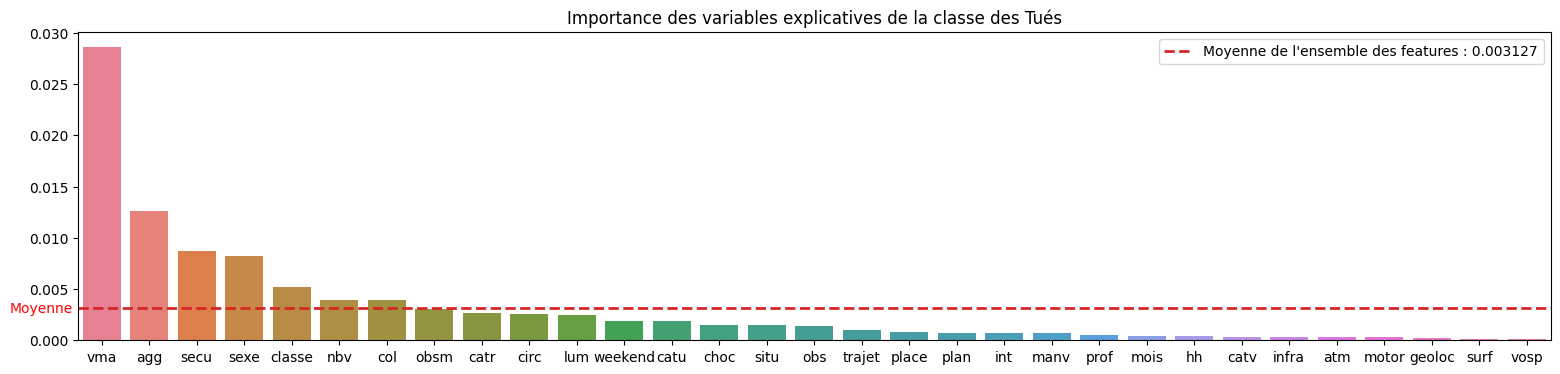

In [4]:

### Moyenne des shap values par variable
df_final_var_mean=pd.DataFrame(df_avg.mean().sort_values(ascending=False)).T

display(df_final_var_mean)

plt.figure(figsize=(19, 4))

# Bar plot de l'importance des variables explicatives
sns.barplot(df_final_var_mean)

# La moyenne total des features
cat_moy=df_avg.mean().mean()
plt.axhline(y=cat_moy, color=plt.cm.tab10(3), linestyle='--', linewidth=2, label=f"Moyenne de l'ensemble des features : {cat_moy:.6f}")
plt.text(-0.6, cat_moy, "Moyenne", color='r', va='center', ha='right')


plt.legend()
plt.title("Importance des variables explicatives de la classe des Tués")
plt.show()

**Remarques:**
>* Les features au dessus de la moyenne dans l'ordre d'importance sont les suivants : **vma,agg,secu,sexe,classe_age,nbv,col,obsm**
>* La vitesse est la feature la plus importante qui domine et dont la valeur est supérieur à la moyenne
>* Finalement les variables explicatives les plus importantes correspondent quasiment aux campagnes de sensiblisation routière , à savoir la vitesse , l'agglomeration ou pas et l'âge

### Fonction d'importance d'une variable

In [5]:

def feature_summary_plot(var_name:str):
    
    mois_columns_with_index = [(index, col) for index, col in enumerate(shap_df.columns) if col.startswith(var_name)]
    
    index_min=min(mois_columns_with_index)[0]
    index_max=max(mois_columns_with_index)[0]
    
    shap.summary_plot(shap_values_csv[:,index_min:index_max+1], X_test.iloc[:, index_min:index_max+1])


### Fonction Summary Plot des variables d'une variable catégorielle

In [6]:

df_shap_var_cat = pd.DataFrame(df_shap.mean().sort_values(ascending=False)).T

def show_categoriel_bar_plot(col_name:str,plot_size=(5,5)):
    #print(f"***** Annalyse des shap values de la variables {col_name} *****")
    for prefix, columns in column_groups.items():
        if prefix==col_name: 
            var_plot = list()
            for c in df_shap_var_cat.columns:                
                if c.startswith(prefix):
                    var_plot.append(c)

            #Plot
            plt.figure(figsize=plot_size)
            ax=sns.barplot(df_shap_var_cat[var_plot])

            #Ligne de la moyenne
            cat_moy=df_shap_var_cat[var_plot].mean().mean()
            #plt.axhline(y=cat_moy, color=plt.cm.tab10(3), linestyle='--', linewidth=2, label='Moyenne')
            plt.axhline(y=cat_moy, color=plt.cm.tab10(3), linestyle='--', linewidth=2, label=f"Moyenne : {cat_moy:.6f}")
            plt.text(-0.6, cat_moy, "Moyenne", color='r', va='center', ha='right')

            #Titre
            plt.title(f"Bar plot shap value de la variable {col_name}")

            plt.legend()
            plt.show()


## Annalyse des features les plus imporatantes:

### Importance la feature **vma** (Vistesse maximale autorisée)

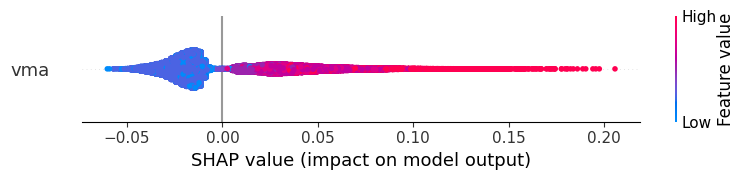

In [7]:
feature_summary_plot("vma")

**Remarques:**
>* vma est la feature la importante de notre model
>* Plus la vitesse maximale autorisée est grande plus on a la chance d'etre tués ( la couleur rouge est plus vive)

### Importance de la feature **agg** (Agglomération)

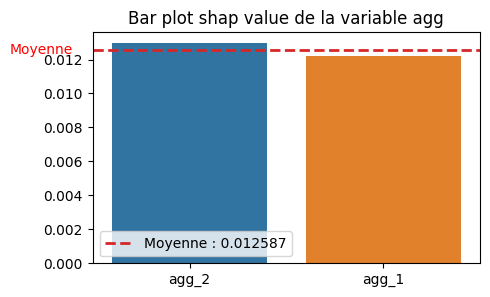

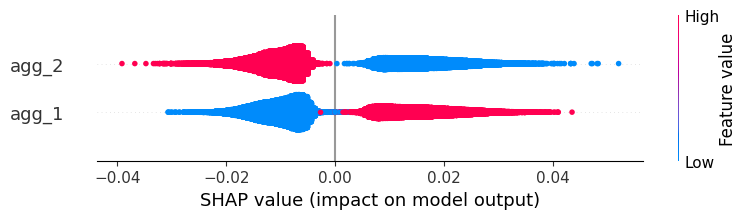

In [8]:
show_categoriel_bar_plot('agg',plot_size=(5,3))
feature_summary_plot("agg")


**Remarques:**
>* agg_1 = Hors agglomération et agg_2 = En agglomeration
>* Le modèle prédit que plus on est en hors agglomération plus on risque d'ètre tué
>* Ce qui est un peut logique car en hors agglomération les vitesses sont plus importantes

### Importance de la feature **sexe**

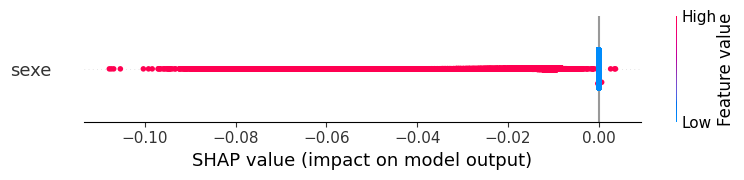

In [11]:
feature_summary_plot("sexe")

**Remarques:**
>* Selon le modèle les hommes ont plus de risque de se faire tuer , contrairement aux femmes

### Importance de la feature **secu** (Présence et utlisation d'un équipement de sécurité)

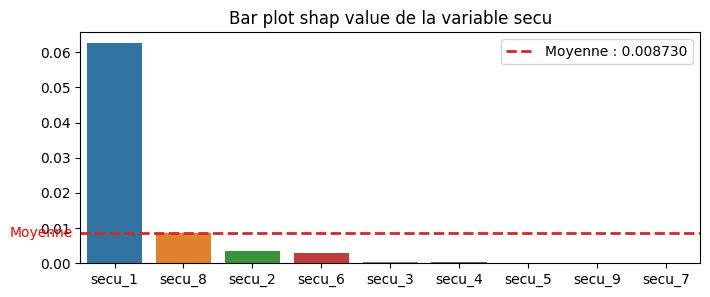

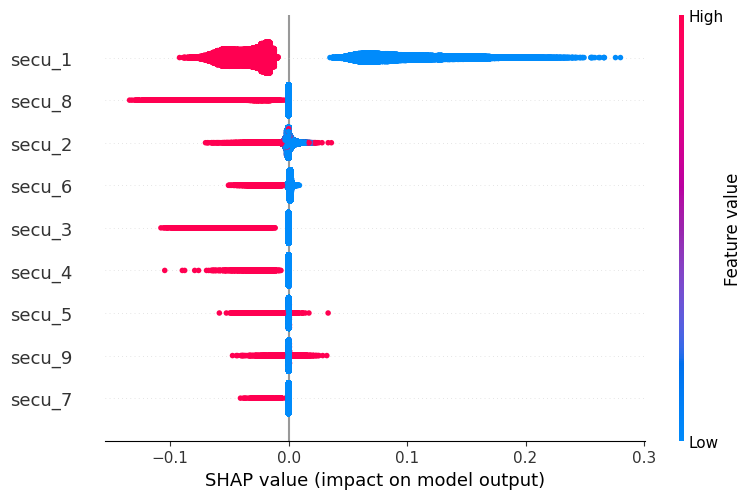

In [9]:
show_categoriel_bar_plot('secu',plot_size=(8,3))
feature_summary_plot("secu")

**Remarques:**
>* La présence du port de la ceinture de sécurité (secu_1) est la variable la plus dominante de la feature
>* Selon le modèle, l'absence du port de la ceinture augmente le risque d'être tué.

### Importance de la feature **nbv** (Nombre de voie)

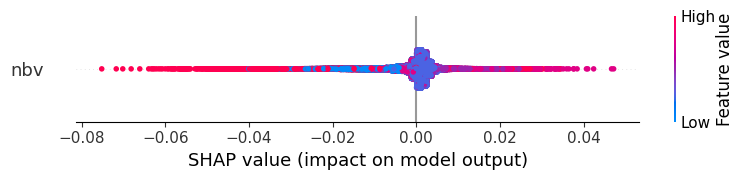

In [12]:
feature_summary_plot("nbv")

***Remarques:***
>* Selon le modèle plus le nombre de voie diminiue plus on risque de se faire tuer

### Importance de la feature **classe_age** (Les classes d'age)
Les classes:
>* 0 : 0-9
>* 1 : 10-17
>* 2 : 18-24
>* 3 : 25-44
>* 4 : 45-65
>* 5 : +65

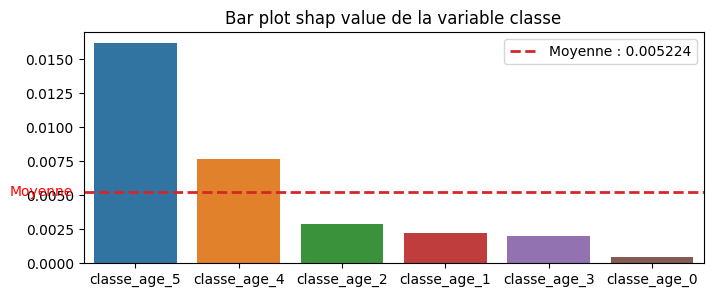

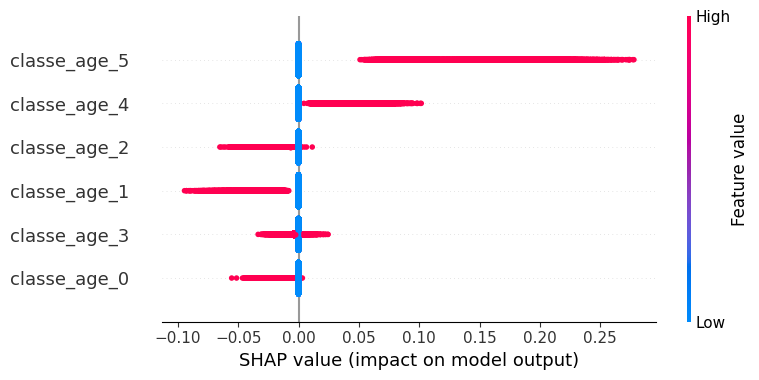

In [13]:
show_categoriel_bar_plot('classe',plot_size=(8,3))
feature_summary_plot("classe")


**Remarques:**
>* Selon le modèle les 45-65 et +65 ans sont plus en risque de se faire tuer contrairement autres classes d'age


### Importance de la feature **col** (Type de colision)

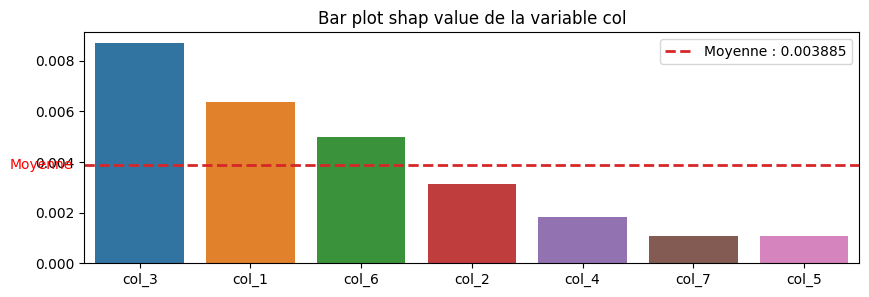

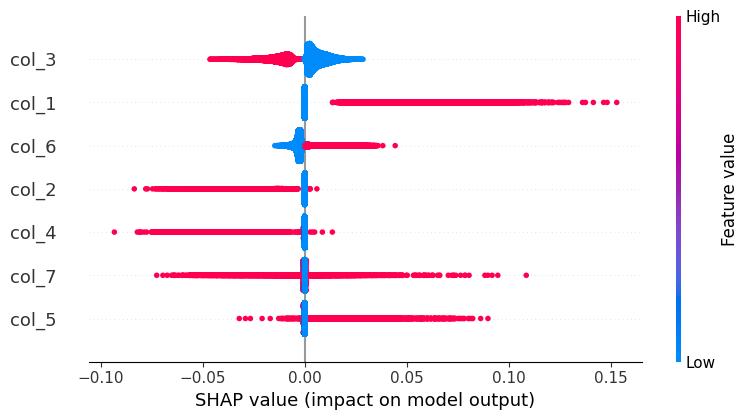

In [14]:
show_categoriel_bar_plot('col',plot_size=(10,3))
feature_summary_plot("col")

**Remarques:**
>* La collison de deux véhicules par le coté (col_3) est la plus importante de la feature
>* Selon le modèle le risque de survit est plus élévée si la colision est de type deux véhicules par le coté (col_3)
>* Et que les colisition catégorisées autre colision (col_6) ont plus de risque de se faire tuer
>* La colision de type frontale (col_1) ne fait que des tués